In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import scanpy as sc
from anndata import AnnData
# import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

- Inputs

In [2]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/dot_plots"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "datasets.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

- Merge relevant info into one dataframe

In [3]:
def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    elif filter_on == 'only_nl':
        df = df[df.neutral_loss != '']
    return df

def filter_adducts(df, filter_on=True, adducts_to_keep=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if filter_on==True:
        df = df[df.adduct.isin(adducts_to_keep)]
    return df


def calculate_detected_intensities(df):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    '''
    intensities_for_twostate_spots = (df.pred_twostate == 1) * df.spot_intensity_bgr_corrected
    df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
    intensities_for_threestate_spots = (df.pred_threestate == 2) * df.spot_intensity_bgr_corrected
    df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
    return df

def filter_polarity(df, filter_on=True, polarity=None):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    if filter_on==True:
        df = df[df['Polarity'] == polarity]
    return df

def group_by_molecule(df, intensity_col_name, prediction_col_name):
    '''
    Aggregate intensity and detection values per class, keep polarity
    '''
    
    if intensity_col_name == 'val_threestate':
        intensity_aggregation_func = lambda x: (x==2).any()
    else: intensity_aggregation_func = lambda x: (x==1).any()
            
    
    data = df.pivot_table(index=['name_short'],
                          columns=['sample_name', 'Polarity'],
                          values=[intensity_col_name, prediction_col_name],
                          aggfunc = {
                                intensity_col_name : lambda x: np.log10(sum(x)+1),
                                prediction_col_name : intensity_aggregation_func
                          },
                          fill_value=0,
                          sort=False)
    data = data.stack(level=[1, 2], dropna=False).reset_index()
    # If no ions on a molecule were detected by matrix, prediction column contains fill value 0 instead of False, correct for that:
    data.at[data[prediction_col_name] == 0, prediction_col_name] = False
    return data

def prep_pca_data(data, polarity_filter_on, intensity_col_name, prediction_col_name, polarity=None, adduct_filter_on=False, adducts_to_keep=None, nl_filter_on=False, neutral_losses_to_keep=None):
    '''
    '''
    
    data = filter_adducts(data, adduct_filter_on, adducts_to_keep)
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_polarity(data, polarity_filter_on, polarity)
    data = group_by_molecule(data, intensity_col_name, prediction_col_name)
    
    return data

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

chem_class = pd.read_csv(p_chem_class, index_col='internal_id')
main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()
pathways = pd.read_csv(p_pathways, index_col='internal_id')
main_pathways = pathways[['name_short', 'main_coarse_path']].drop_duplicates()

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Clone ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code']] # 'Participant lab', 'Technology'
datasets_info['sample_name'] = datasets_info['Matrix short']
# datasets_info['sample_name'] = datasets_info['Matrix short'] + '_' + datasets_info['Slide code']

# Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Clone ID', how='left')

### Part 1: PCA based on the coarse class dot plot

In [5]:
# # Choose colourmap
# cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

In [6]:
def summarise_per_coarse_class(df, class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] = 1
    data = df.pivot_table(index=['sample_name', 'Polarity'],
                                   columns=class_col_name,
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=1, dropna=False).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']
    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')    
    return data

<ipython-input-3-957770b15754>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-3-957770b15754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = o

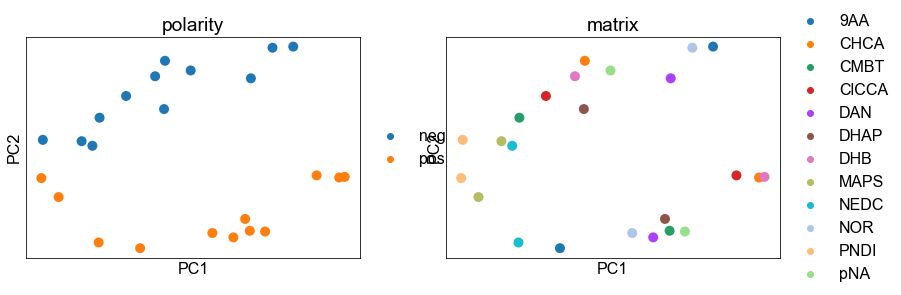

In [14]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_pca_data(df,
                   polarity_filter_on=False,
                   adduct_filter_on=False,
                   adducts_to_keep=None,
                   nl_filter_on=True, 
                   neutral_losses_to_keep=[''], 
                   intensity_col_name='val_threestate',
                   prediction_col_name = 'pred_threestate')

# Map chemical classes
mapped_data = molecule_data.merge(main_chem_class, on='name_short', how='left') #chem_class of pathways

# Summarise data per class
class_data = summarise_per_coarse_class(mapped_data,
                                        class_col_name='main_coarse_class',
                                        intensity_col_name ='val_threestate',
                                        prediction_col_name = 'pred_threestate')

# Reshape into AnnData
pca = class_data.pivot_table(values=['val_threestate', 'fraction_detected'], 
                       index=['sample_name', 'Polarity'], 
                       columns='main_coarse_class')
pca = pca.reset_index()
adata = AnnData(pca.drop(columns=['sample_name', 'Polarity']),
               obs = {'matrix':pca.sample_name.values,
                     'polarity':pca.Polarity.values})

# Apply Z-score normalisation
sc.pp.scale(adata, zero_center=True)

# Compute and plot PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, components=['1, 2'], color=['polarity', 'matrix'], size=400, ncols=2, legend_loc='right margin')

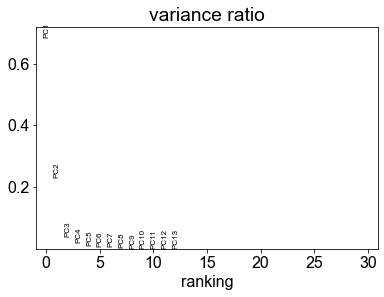

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


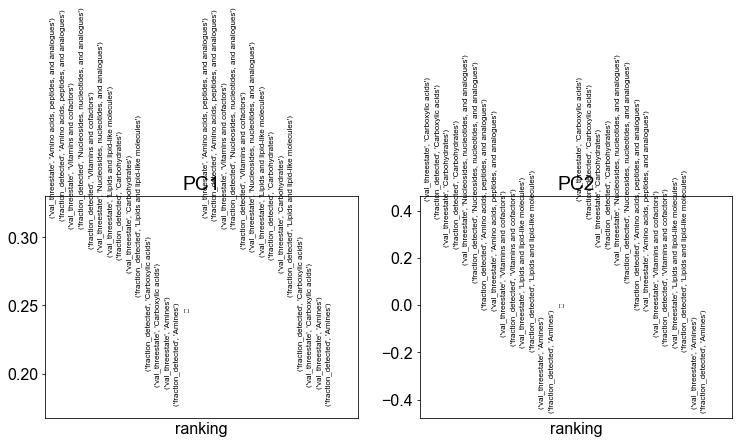

In [15]:
# Extras

# see how much PCA components explain variance
sc.pl.pca_variance_ratio(adata)

# check loading plot
sc.pl.pca_loadings(adata, components='1,2')

## Part 2: Dot plot with fine chemical classes

In [9]:
def summarise_per_fine_class(df, fine_class_col_name, coarse_class_col_name, intensity_col_name, prediction_col_name):
    
    df['class_size'] =1
    data = df.pivot_table(index=['sample_name', 'Polarity'],
                                   columns=[fine_class_col_name, coarse_class_col_name],
                                   values=[intensity_col_name, prediction_col_name, 'class_size'],
                                   aggfunc = {
                                        'class_size':sum,
                                        prediction_col_name : sum,
                                        intensity_col_name : np.mean
                                   },
                                   fill_value=0,
                                   sort=False)
    
    data = data.stack(level=[1,2], dropna=True).reset_index()
    data['fraction_detected'] = data[prediction_col_name] / data['class_size']    
    
    # sort columns alphabetically
    data = data.sort_values(by='sample_name')
    # sort rows first by coarse class, then by fine class
    data = data.sort_values(by=[coarse_class_col_name, fine_class_col_name])
    return data


In [10]:
# # Choose colourmap
# cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

<ipython-input-3-957770b15754>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-3-957770b15754>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = o

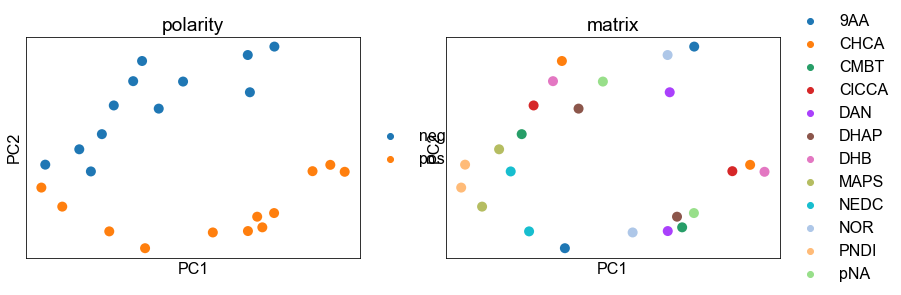

In [11]:
# Summarise data per molecule (intensities of its detected ions are summed)
molecule_data = prep_pca_data(df,
                              polarity_filter_on=False,
                                   adduct_filter_on=False,
                                   adducts_to_keep=None,
                                   nl_filter_on=True, 
                                   neutral_losses_to_keep=[''], 
                                   intensity_col_name='val_threestate',
                                   prediction_col_name = 'pred_threestate')

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left') #pathways or chem_class

# Summarise data per class
class_data = summarise_per_fine_class(mapped_data,
                                      fine_class_col_name='fine_class',
                                      coarse_class_col_name='coarse_class',
                                      intensity_col_name ='val_threestate',
                                      prediction_col_name = 'pred_threestate')

# Reshape into AnnData
pca = class_data.pivot_table(values=['val_threestate', 'fraction_detected'], 
                       index=['sample_name', 'Polarity'], 
                       columns='fine_class')

pca = pca.reset_index()
adata = AnnData(pca.drop(columns=['sample_name', 'Polarity']),
               obs = {'matrix':pca.sample_name.values,
                     'polarity':pca.Polarity.values})

# Apply Z-score normalisation
sc.pp.scale(adata, zero_center=True)

# Compute and plot PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, components=['1, 2'], color=['polarity', 'matrix'], size=400, ncols=2, legend_loc='right margin')

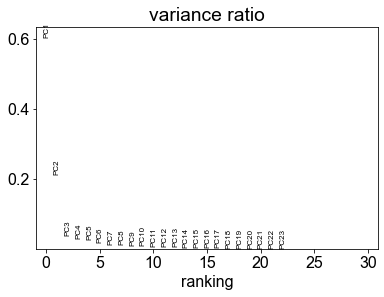

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


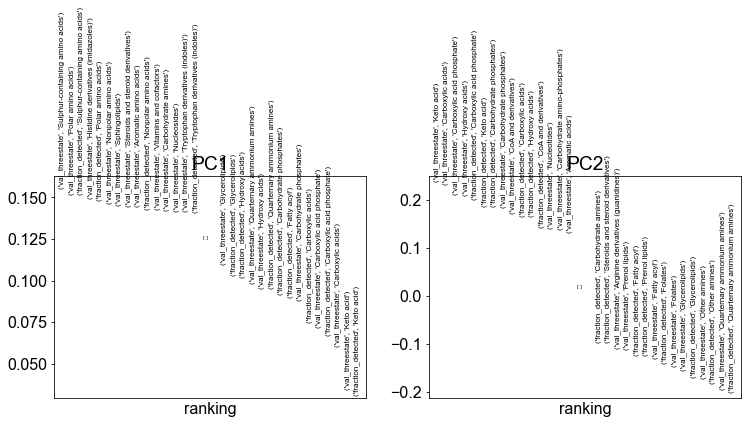

In [12]:
# Extras

# see how much PCA components explain variance
sc.pl.pca_variance_ratio(adata)

# check loading plot
sc.pl.pca_loadings(adata, components='1,2')